# Data Imports and EDA

We have 2 data types : training_variants and training_text

training_variant has ID, Gene, class

training_text has ID, text

In [3]:
# !rm ../root/.kaggle
# !mkdir ../root/.kaggle/
# !cp kaggle.json ../root/.kaggle/

In [4]:
# !pip install kaggle
!kaggle competitions download -c msk-redefining-cancer-treatment

 95% 161M/169M [00:01<00:00, 148MB/s]
100% 169M/169M [00:01<00:00, 139MB/s]


In [5]:
# !ls ../root/.kaggle

In [6]:
from zipfile import ZipFile
with ZipFile('/content/msk-redefining-cancer-treatment.zip', 'r') as archive:
  archive.extractall('/content/cancer/') 
with ZipFile('/content/cancer/training_text.zip', 'r') as archive:
  archive.extractall('/content/cancer/') 
with ZipFile('/content/cancer/training_variants.zip', 'r') as archive:
  archive.extractall('/content/cancer/') 

In [7]:
import pandas as pd #reading the dataset

In [8]:
data=pd.read_csv('/content/cancer/training_variants')

In [9]:
# print('(no of data points,no of features) =',data.shape)
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [10]:
text_data=pd.read_csv("/content/cancer/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
text_data.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
import re
from nltk.corpus import stopwords

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stop_words = set(stopwords.words('english'))

#function given below preprocesses given row text
def nlp_preprocessing(total_text, index, column): 
    if type(total_text) is not int:
        string = ""
        # replace special character with spaces and removing multiple spaces, also converting everything to lower case
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+',' ', total_text).lower()
        
        for word in total_text.split():
        # removing stop words
            if not word in stop_words:
                string += word + " "
        
        text_data.loc[index, column] = string

In [14]:
# preprosessing our text
for index, row in text_data.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("No text description for id:",index)

No text description for id: 1109
No text description for id: 1277
No text description for id: 1407
No text description for id: 1639
No text description for id: 2755


In [15]:
# text_data.head()

In [16]:
# merging data and text_data
result = pd.merge(data, text_data,on='ID', how='left')
result.loc[result.isnull().any(axis=1)] # locating null values of 'text'

# relplacing null values with GENE+VARIATION on text because no text present
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']
# result

#Train ,Test and Cross validation split 64% Train, 16% Cross-Validation, 20% Test

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train such that frequency of all class are as same as possible in both  [stratify=y_true]
X_train_cv, X_test, y_train_cv, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation such that frequency of all class are as same as possible in both [stratify=y_train_cv]
X_train, X_cv, y_train, y_cv = train_test_split(X_train_cv, y_train_cv, stratify=y_train_cv, test_size=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# print('Number of data points in train data:', X_train.shape[0])
# print('Number of data points in test data:', X_test.shape[0])
# print('Number of data points in cross validation data:', X_cv.shape[0])

In [20]:
import numpy as np
import matplotlib.pyplot as plt

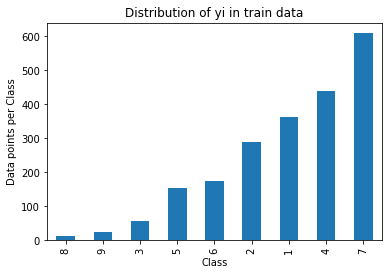

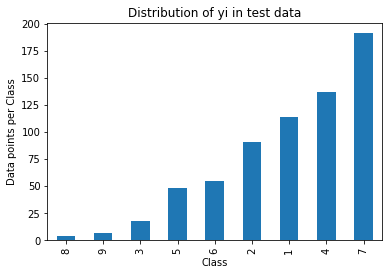

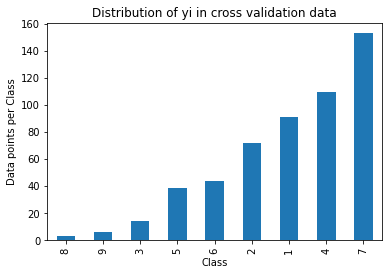

In [21]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = X_train['Class'].value_counts().sort_values()
test_class_distribution = X_test['Class'].value_counts().sort_values()
cv_class_distribution = X_cv['Class'].value_counts().sort_values()

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')

plt.figure()
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')

plt.figure()
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data');

# Machine learning Models

## random (Base) model

In [22]:
from sklearn.metrics import confusion_matrix,log_loss
import seaborn as sns

In [23]:
# This function plots the confusion matrices given y_i, y_i_hat.
# picked from google
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)  
    B =(C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [24]:
# Generating random probabilites
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# Creating output array of exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on CV Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

# Creating output array of exactly same size as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))



# predicted_y =np.argmax(test_predicted_y, axis=1)
#plot_confusion_matrix(y_test, predicted_y+1)

Log loss on CV Data using Random Model 2.5488788148753794
Log loss on Test Data using Random Model 2.4714105914983504


## Univariate Analysis

In [25]:
# # gives gene variation feature Dict
# def get_gv_fea_dict(alpha, feature, df):

#     value_count = X_train[feature].value_counts()
    
#     # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
#     gv_dict = dict()
    
#     # denominator will contain the number of time that particular feature occured in whole data
#     for i, denominator in value_count.items():
#         # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
#         # vec is 9 dimensional vector
#         vec = []
#         for k in range(1,10):


#             cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            
#             # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
#             vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

#         # we are adding the gene/variation to the dict as key and vec as value
#         gv_dict[i]=vec
#     return gv_dict

# # Get Gene variation feature
# def get_gv_feature(alpha, feature, df):

#     gv_dict = get_gv_fea_dict(alpha, feature, df)
#     # value_count is similar in get_gv_fea_dict
#     value_count = X_train[feature].value_counts()
    
#     gv_fea = []
#     for index, row in df.iterrows():
#         if row[feature] in dict(value_count).keys():
#             gv_fea.append(gv_dict[row[feature]])
#         else:
#             gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#     return gv_fea

#### Univariate analysis on Gene

In [26]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 238
BRCA1     175
TP53      110
EGFR      103
PTEN       82
BRCA2      80
KIT        62
BRAF       60
ERBB2      49
PDGFRA     42
ALK        40
Name: Gene, dtype: int64


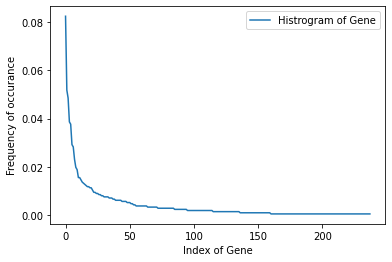

In [27]:
plt.figure()
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Gene")
plt.xlabel('Index of Gene')
plt.ylabel('Frequency of occurance')
plt.legend();

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
#encoding of Gene feature 
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene']) 

In [30]:
# gene_vectorizer.get_feature_names()[:10] 
# pd.DataFrame(train_gene_feature_onehotCoding)
X_train['Gene']

2901       NF2
1668      FLT3
2732      BRAF
2179      PTEN
872     PDGFRA
         ...  
2892     BRCA2
589      SMAD4
655     CDKN2A
1404     FGFR3
1368      AKT2
Name: Gene, Length: 2124, dtype: object

In [31]:
print("Shape of encoded gene featurizer:", train_gene_feature_onehotCoding.shape)

Shape of encoded gene featurizer: (2124, 237)


In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

For alpha =  1e-05 The log loss is: 1.2410118474862937
For alpha =  0.0001 The log loss is: 1.213623386214203
For alpha =  0.001 The log loss is: 1.236298078702474
For alpha =  0.01 The log loss is: 1.3316740662152697
For alpha =  0.1 The log loss is: 1.4378784770201882
For alpha =  1 The log loss is: 1.4707943082280153
For best alpha =  0.0001 The train log loss is: 1.001107095120326
For best alpha =  0.0001 The cross validation log loss is: 1.213623386214203
For best alpha =  0.0001 The test log loss is: 1.141741011365763


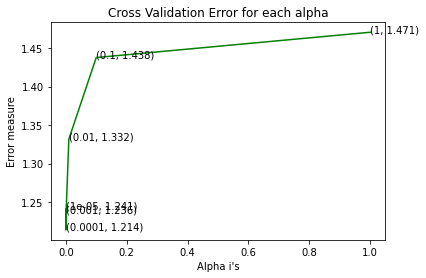

In [34]:
alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [35]:
test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]


In [36]:
print("Percentage of data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset:")
print(' In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print(' In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Percentage of data points in Test and CV datasets are covered by the  238  genes in train dataset:
 In test data 650 out of 665 : 97.74436090225564
 In cross validation data 518 out of  532 : 97.36842105263158


#### Univariate analysis on Variation

In [37]:
unique_variation = X_train['Variation'].value_counts()
print('Number of Unique Variation :', unique_variation.shape[0])
# the top 10 Variation that occured most
print(unique_variation.head(10))

Number of Unique Variation : 1925
Truncating_Mutations    59
Amplification           55
Deletion                39
Fusions                 23
Overexpression           5
G12V                     3
M1R                      2
G12C                     2
G12A                     2
EWSR1-ETV1_Fusion        2
Name: Variation, dtype: int64


In [38]:
test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]


In [39]:
# print("Percentage of data points in Test and CV datasets are covered by the ", unique_variation.shape[0], " genes in train dataset:")
# print(' In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
# print(' In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

#### Univariate analysis on Text

In [40]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = {}
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] = dictionary.get(word, 0)+1
    return dictionary

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total unique words in train :", len(train_text_features))

Total unique words in train : 52985


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j].get(i, 0)+10 )/(total_dict.get(i, 0) + 90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [45]:
#import math
# from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize

In [46]:
# normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

For values of alpha =  1e-05 The log loss is: 1.2552626137820544
For values of alpha =  0.0001 The log loss is: 1.1703293849874488
For values of alpha =  0.001 The log loss is: 1.203485190719142
For values of alpha =  0.01 The log loss is: 1.3220330133213734
For values of alpha =  0.1 The log loss is: 1.4003595709814056
For values of alpha =  1 The log loss is: 1.5987480470991449


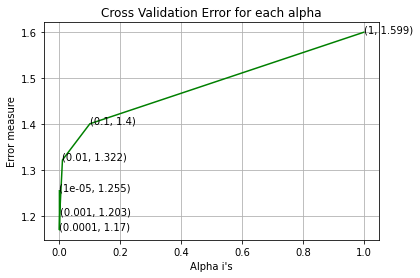

For values of best alpha =  0.0001 The train log loss is: 0.5986915908286562
For values of best alpha =  0.0001 The cross validation log loss is: 1.1703293849874488
For values of best alpha =  0.0001 The test log loss is: 1.0624775934169994


In [47]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]



cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [48]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [49]:
# len1,len2 = get_intersec_text(X_test)
# print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data") 
# len1,len2 = get_intersec_text(X_cv)
# print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

In [50]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [51]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [52]:
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

In [53]:
import scipy

In [54]:
train_gene_var_onehotCoding = scipy.sparse.hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = scipy.sparse.hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = scipy.sparse.hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = scipy.sparse.hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = scipy.sparse.hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = scipy.sparse.hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_cv['Class']))



In [55]:
# print("One hot encoding features :")
# print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
# print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
# print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

## Model 1 : Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB

for alpha = 1e-05
Log Loss : 1.2661699567335918
for alpha = 0.0001
Log Loss : 1.2667010982472504
for alpha = 0.001
Log Loss : 1.2601712628507555
for alpha = 0.1
Log Loss : 1.277457497443234
for alpha = 1
Log Loss : 1.298167570976977
for alpha = 10
Log Loss : 1.3468573897721177
for alpha = 100
Log Loss : 1.3024792325492125
for alpha = 1000
Log Loss : 1.2719465577031135


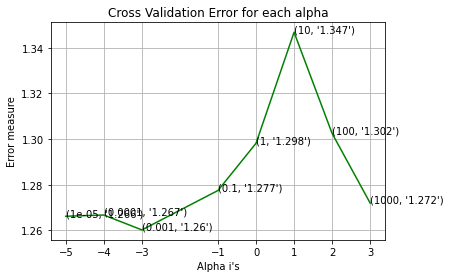

For values of best alpha =  0.001 The train log loss is: 0.8156274628025738
For values of best alpha =  0.001 The cross validation log loss is: 1.2601712628507555
For values of best alpha =  0.001 The test log loss is: 1.2491647348265322


In [57]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [58]:
clf = MultinomialNB(alpha=alpha[best_alpha]) 
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
# plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

Log Loss : 1.2601712628507555
Number of missclassified point : 0.38721804511278196


## Model 2 K nearest neighbours

In [59]:
from sklearn.neighbors import KNeighborsClassifier

for alpha = 1
Log Loss : 1.3590067594367863
for alpha = 2
Log Loss : 1.2695849245603108
for alpha = 3
Log Loss : 1.248321815669227
for alpha = 4
Log Loss : 1.2393982448333951
for alpha = 5
Log Loss : 1.2576649332218424
for alpha = 6
Log Loss : 1.2803831307815667


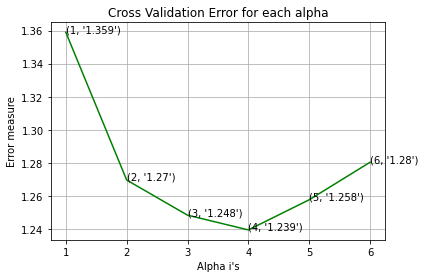

For values of best alpha =  4 The train log loss is: 0.9042176974990692
For values of best alpha =  4 The cross validation log loss is: 1.2393982448333951
For values of best alpha =  4 The test log loss is: 1.2686399189716804


In [60]:

alpha = [x for x in range(1,7,1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.2393982448333951
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


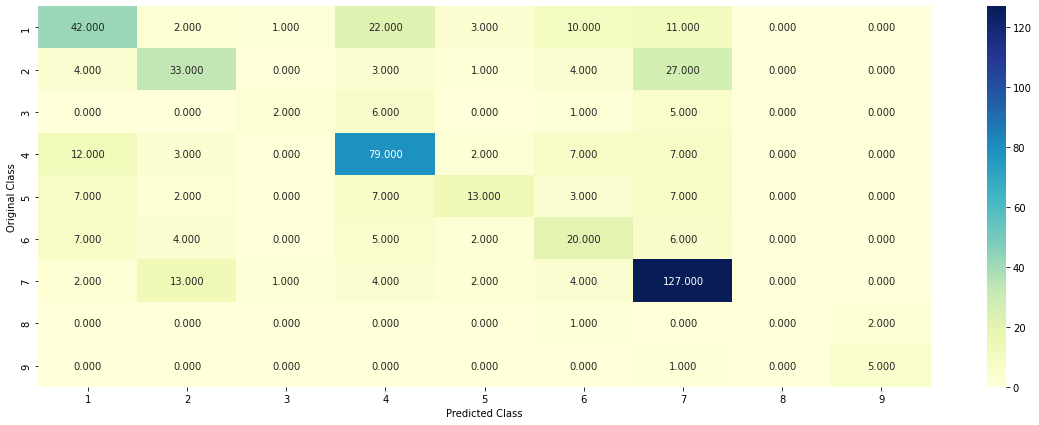

-------------------- Precision matrix (Columm Sum=1) --------------------


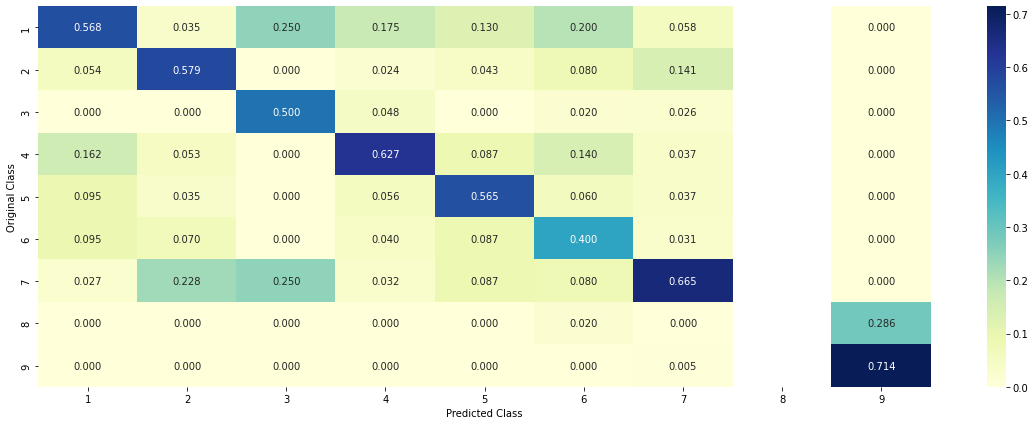

-------------------- Recall matrix (Row sum=1) --------------------


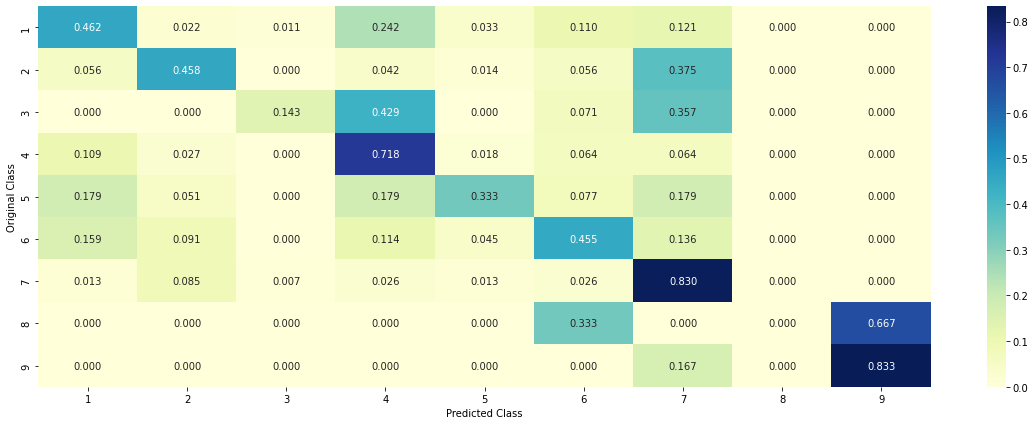

In [61]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha]) 
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf) 

## Model 3 Logistic regression 

for alpha = 1e-06
Log Loss : 1.3107200177031169
for alpha = 1e-05
Log Loss : 1.2609327845762694
for alpha = 0.0001
Log Loss : 1.1168367659364236
for alpha = 0.001
Log Loss : 1.1379584826986242
for alpha = 0.01
Log Loss : 1.2231040132514854
for alpha = 0.1
Log Loss : 1.2895224028611396
for alpha = 1
Log Loss : 1.4890762804631912
for alpha = 10
Log Loss : 1.5288300830327193
for alpha = 100
Log Loss : 1.533381945388375


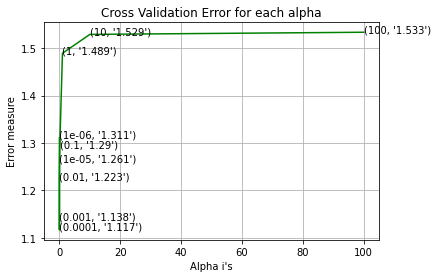

For values of best alpha =  0.0001 The train log loss is: 0.4533306509722412
For values of best alpha =  0.0001 The cross validation log loss is: 1.1168367659364236
For values of best alpha =  0.0001 The test log loss is: 1.0281139637443306


In [62]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1168367659364236
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


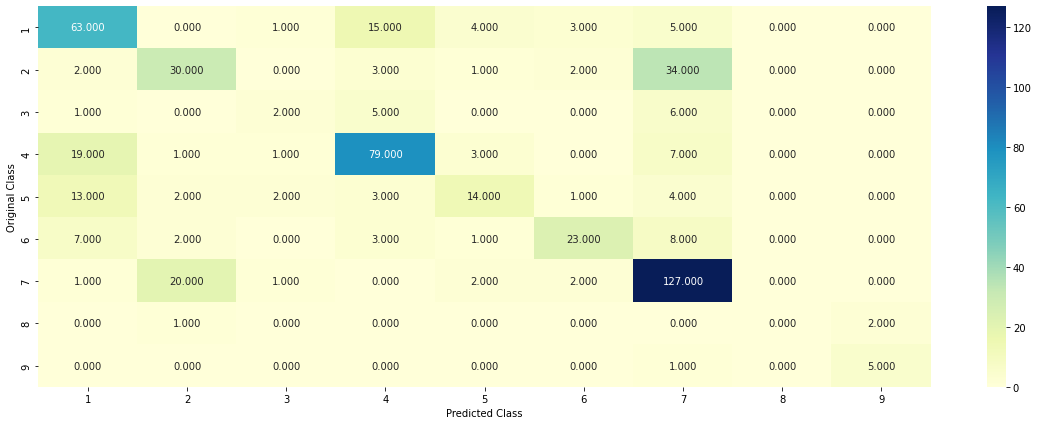

-------------------- Precision matrix (Columm Sum=1) --------------------


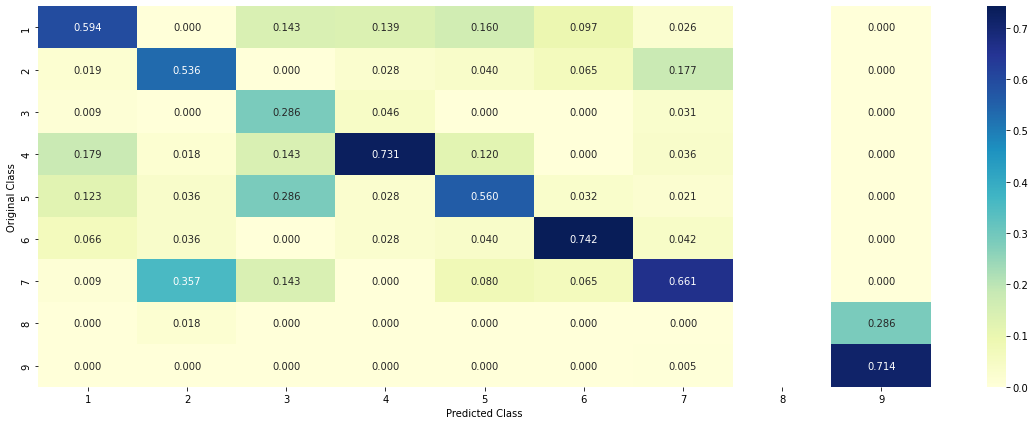

-------------------- Recall matrix (Row sum=1) --------------------


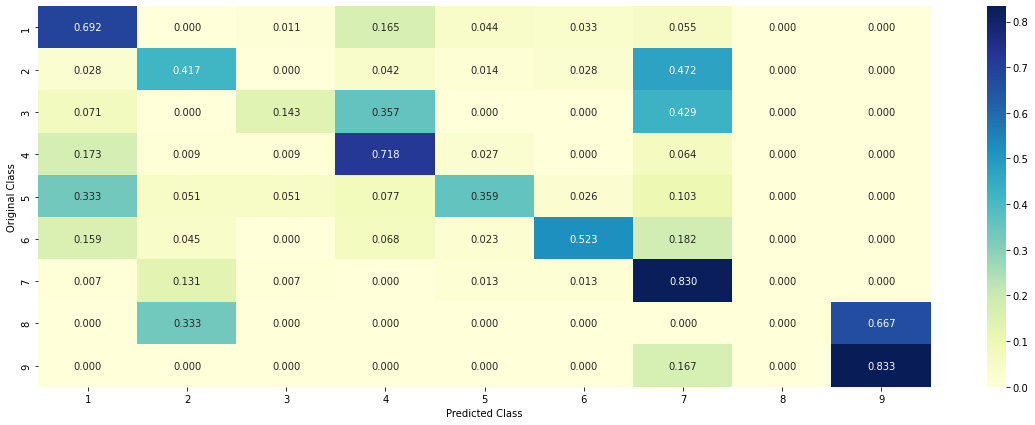

In [63]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## Model 4 Linear SVM

for C = 1e-05
Log Loss : 1.2821097094985263
for C = 0.0001
Log Loss : 1.201134103156683
for C = 0.001
Log Loss : 1.1209228360694585
for C = 0.01
Log Loss : 1.174963246792715
for C = 0.1
Log Loss : 1.304069777441766
for C = 1
Log Loss : 1.534870884155619
for C = 10
Log Loss : 1.5342525266949927
for C = 100
Log Loss : 1.5342650565992897


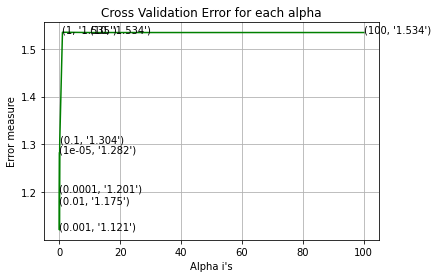

For values of best alpha =  0.001 The train log loss is: 0.5209665747170256
For values of best alpha =  0.001 The cross validation log loss is: 1.1209228360694585
For values of best alpha =  0.001 The test log loss is: 1.0859970388321554


In [64]:

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1209228360694585
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


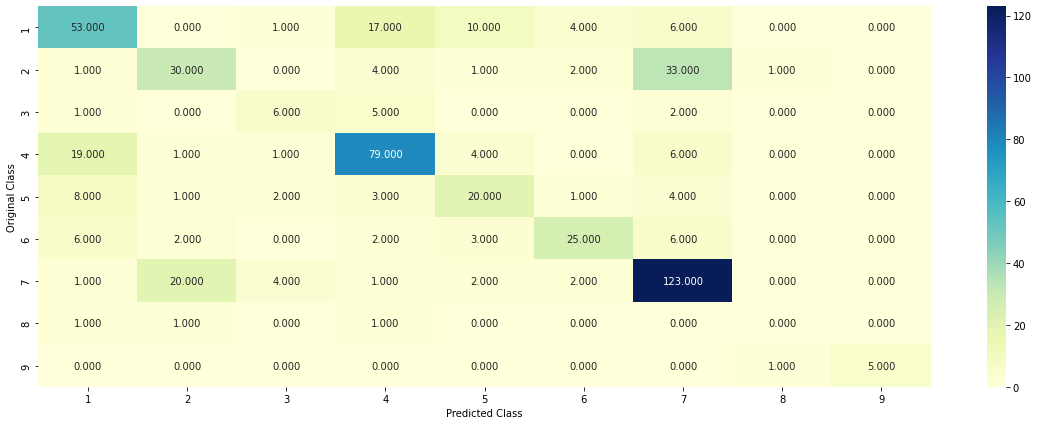

-------------------- Precision matrix (Columm Sum=1) --------------------


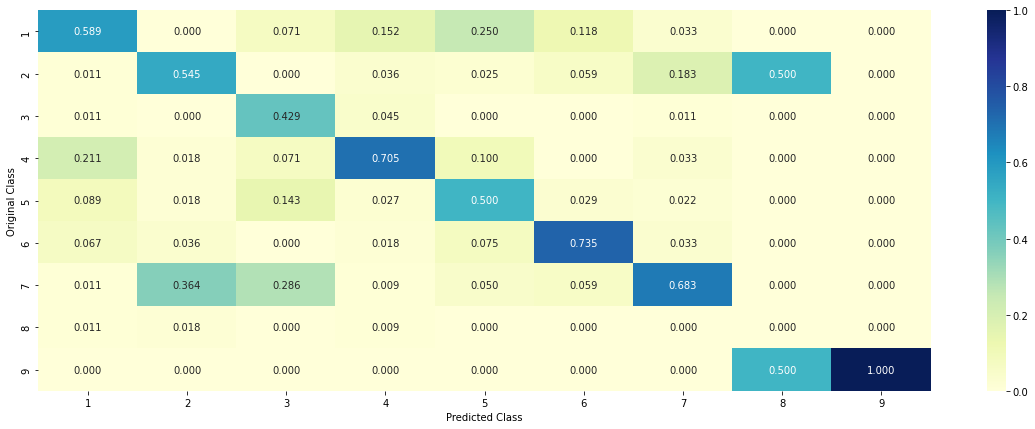

-------------------- Recall matrix (Row sum=1) --------------------


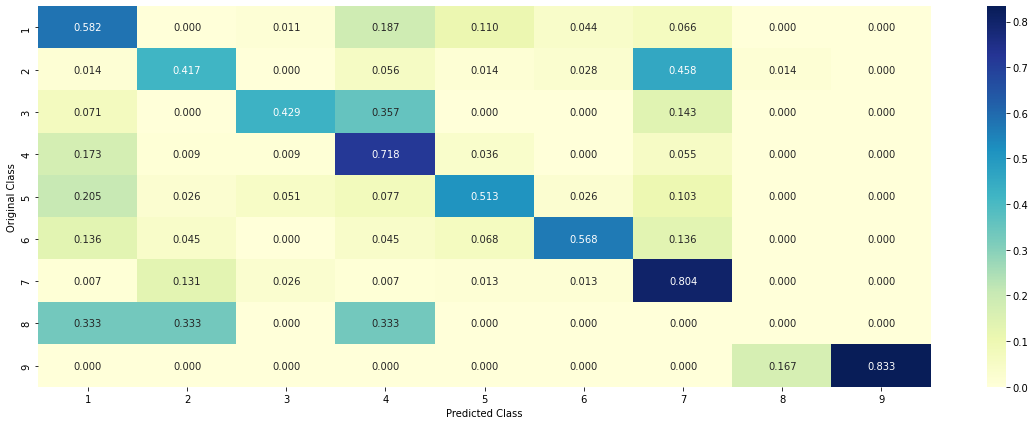

In [65]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## Model 5 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2276680808689555
for n_estimators = 100 and max depth =  10
Log Loss : 1.1731836627645473
for n_estimators = 200 and max depth =  5
Log Loss : 1.2198101839824098
for n_estimators = 200 and max depth =  10
Log Loss : 1.166747360181489
for n_estimators = 500 and max depth =  5
Log Loss : 1.2080277759028004
for n_estimators = 500 and max depth =  10
Log Loss : 1.164528365807827
for n_estimators = 1000 and max depth =  5
Log Loss : 1.203607349843806
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1624015273958888
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2023226567133065
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1618217464350007
For values of best estimator =  2000 The train log loss is: 0.6372112334432398
For values of best estimator =  2000 The cross validation log loss is: 1.161821746435001
For values of best estimator =  2000 The test log loss is: 1.1103724122074645


Log loss : 1.1618217464350007
Number of mis-classified points : 0.3815789473684211
-------------------- Confusion matrix --------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


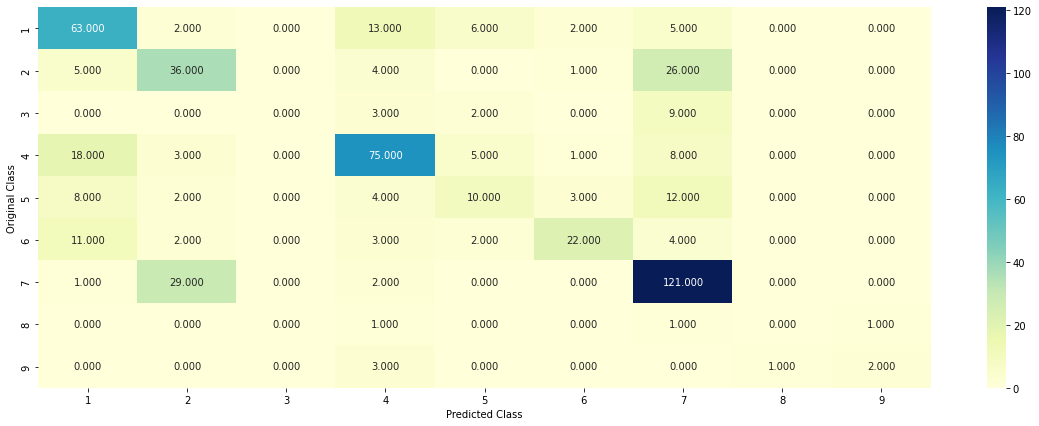

-------------------- Precision matrix (Columm Sum=1) --------------------


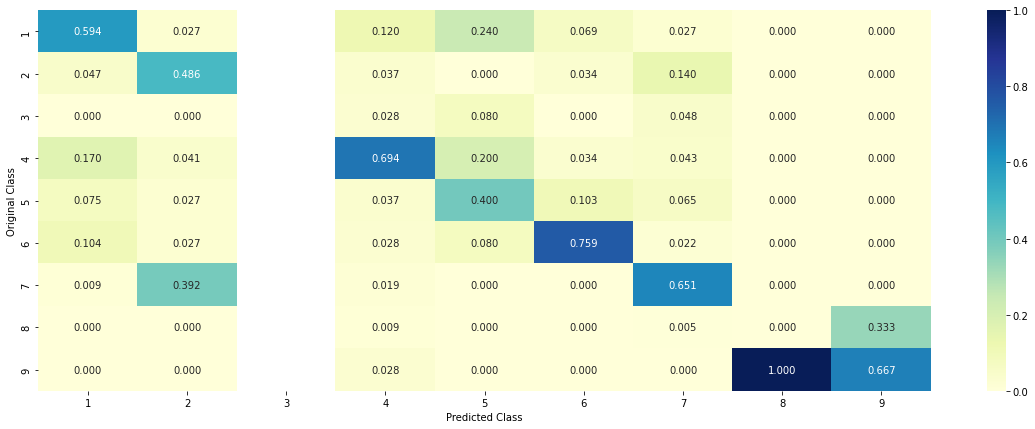

-------------------- Recall matrix (Row sum=1) --------------------


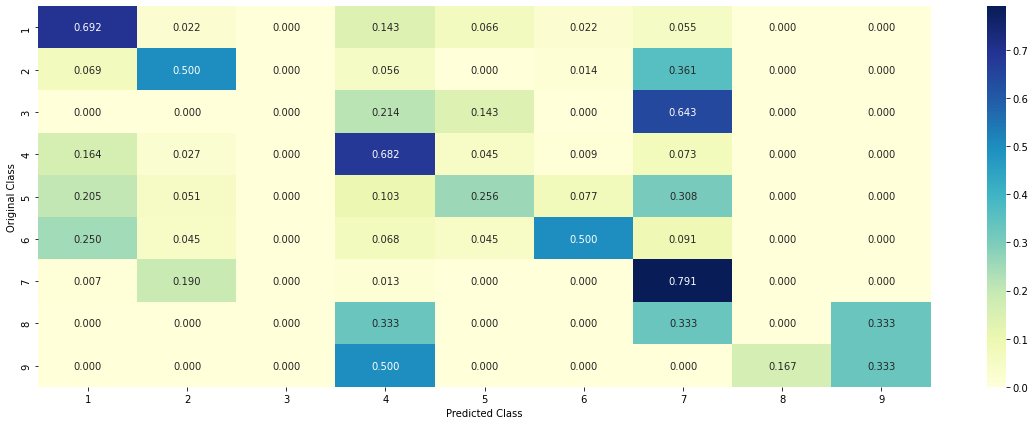

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## Majority Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=1000 )
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

Log loss (train) on the VotingClassifier : 0.5987648349896085
Log loss (CV) on the VotingClassifier : 1.0644812530015824
Log loss (test) on the VotingClassifier : 1.011924766397704
Number of missclassified point : 0.3458646616541353
-------------------- Confusion matrix --------------------


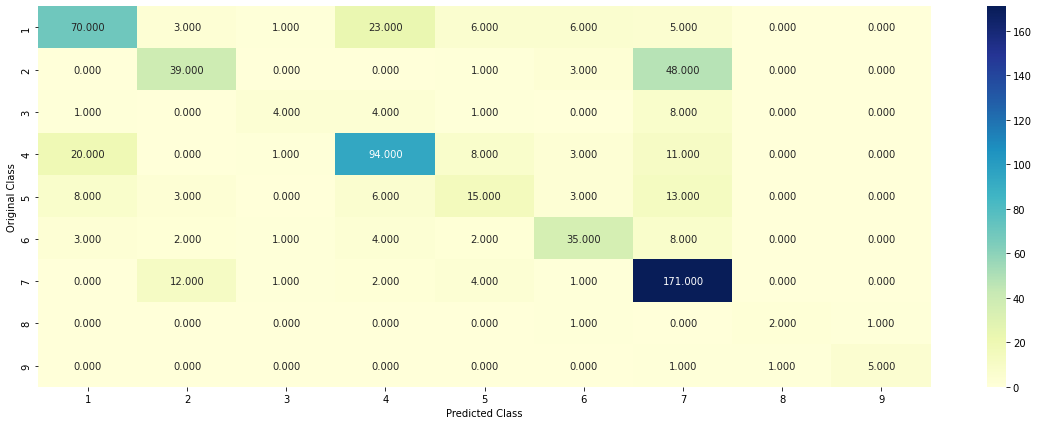

-------------------- Precision matrix (Columm Sum=1) --------------------


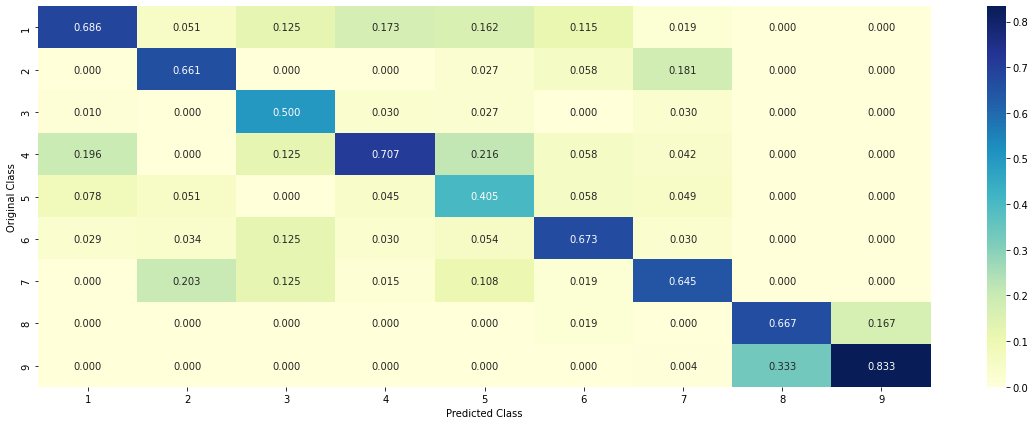

-------------------- Recall matrix (Row sum=1) --------------------


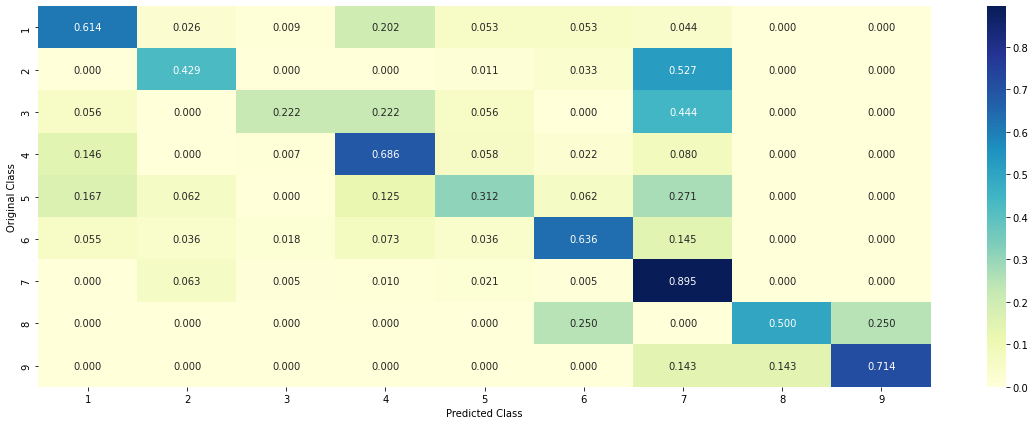

In [ ]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))